<h1 style="text-align: center;">Testing MC Notebook</h1>
<h3 style="text-align: center;">Diego Ontiveros</h3>

<center>In this notebook different aspects of the Monte Carlo program will be tested separatedly to secure all works well and is as optimized as possible.</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline

Testing the rotation matrices and visualization of coordinates

In [2]:
def rotate(Ax,Ay,Az,testCoord,atype="deg"):
        """Rotates the molecule a specified angle (in degrees) for each main axis."""
        atype = atype.lower()
        if atype == "deg" or atype == "d": Ax,Ay,Az = np.radians(Ax),np.radians(Ay),np.radians(Az)
        elif atype == "rad" or atype == "r": pass
        else: raise TypeError("Angle type not detected. Choose deg for degrees or rad for radians.")

        # Rotation matrices
        Rx = np.array([[1,0,0],[0,np.cos(Ax),-np.sin(Ax)],[0,np.sin(Ax),np.cos(Ax)]])
        Ry = np.array([[np.cos(Ay),0,np.sin(Ay)],[0,1,0],[-np.sin(Ay),0,np.cos(Ay)]])
        Rz = np.array([[np.cos(Az),-np.sin(Az),0],[np.sin(Az),np.cos(Az),0],[0,0,1]])

        # Rotates the molecule the specified angles
        for i in range(3):
            for _,R in enumerate([Rx,Ry,Rz]):
                ctemp = testCoord[i].copy()
                testCoord[i] = np.dot(R,ctemp) 

def draw(coord,ax):
        ax.scatter(coord.T[0],coord.T[1],coord.T[2], sizes=(100,75,75), c=("red","grey","grey"), alpha=True)

[[ 0.       0.       0.     ]
 [-0.58589  0.75669  0.     ]
 [-0.58589 -0.75669  0.     ]]


Text(0.5, 0, 'z')

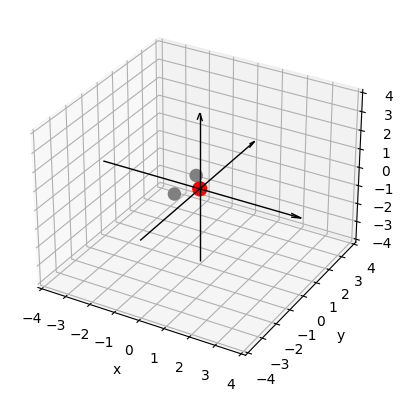

In [3]:
# Testing Rotation
axes = np.array([[1,0,0],[0,1,0],[0,0,1]])
water = np.array([[0.,0.,0.],[0.75669,0.58589,0.],[-0.75669,0.58589,0.]])
coord = water

rotate(0,0,90,coord)
print(coord)

# Testing Visualization
fig = plt.figure()
ax = plt.axes(projection="3d")
draw(coord,ax)

lim = 4 #box limit
ax.quiver(-lim, 0, 0, 2*lim, 0, 0, color='k',lw=1, arrow_length_ratio=0.05)     # x-axis
ax.quiver(0, -lim, 0, 0, 2*lim, 0, color='k',lw=1, arrow_length_ratio=0.05)     # y-axis
ax.quiver(0, 0, -lim, 0, 0, 2*lim, color='k',lw=1, arrow_length_ratio=0.05)     # z-axis
ax.set_xlim(-lim,lim);ax.set_ylim(-lim,lim);ax.set_zlim(-lim,lim)               # Box limits
ax.set_xlabel("x");ax.set_ylabel("y");ax.set_zlabel("z")                        # Axis Labels

In [4]:
#Energies parameters (VdW A and B, and coulomb charges)
A = np.array([[581935.563838,328.317371,328.317371],
            [328.317371,9.715859e-6,9.715859e-6],
            [328.317371,9.715859e-6,9.715859e-6]])
B = np.array([[594.825035,10.478040,10.478040],
            [10.478040,0.001337,0.001337],
            [10.478040,0.001337,0.001337]])
q = np.array([-0.834,+0.417,+0.417])
Q = np.dot(q[:,None],q[:,None].T)

coord1 = np.array([[-3.843,  -4.381,   2.479],
                [-2.987,  -4.032,   2.783],
                [-4.475,  -3.954,   3.055]])
coord2 = np.array([[-1.523,  -3.299,   3.460],
                [-1.041,  -2.606,   3.024],
                [-0.912,  -3.781,   4.007]])

In [5]:
def coulomb(qi,qj,r):
    """Returns coulomb energy between i-j pair."""
    kcal = 332.0 #To return the results in kcal/mol
    return kcal*qi*qj/r

def vdW(A,B,r):
    """Returns Van der Waals energy between i-j pair."""
    return A/r**12 - B/r**6


def looping(coord1,coord2):
        """Gets energy by looping each molecule coordinates"""
        n1 = len(coord1)
        n2 = len(coord2)

        E,Eelec,Evdw = 0,0,0
        for i in range(n1):      # For each atom in molecule 1
            for j in range(n2):  # For each atom in molecule 2
                r = np.linalg.norm(coord2[j]-coord1[i]) 
                # Calculadas a pares de c[1]-c[2] (no energias interas) 
                Evdw += vdW(A[i][j],B[i][j],r)
                Eelec += coulomb(q[i],q[j],r)
        E = Eelec+Evdw  
        return E,Eelec,Evdw

def numpyHand(coord1,coord2):
    """Gets energy using numpy arrays broadcasting and matrix operations"""

    diff = coord1-coord2[:,None]
    distances = np.sqrt((diff**2).sum(axis=-1)).T
    
    Evdw = (A/distances**12 - B/distances**6).sum()
    Eelec = (332.0*Q/distances).sum()
    E = Evdw + Eelec

    return E,Eelec,Evdw

def numpyLinalg(coord1,coord2):
    """Same as NumpyHand but using linalg.norm"""

    diff = coord1-coord2[:,None]
    distances = np.linalg.norm(diff, axis=-1).T

    Evdw = (A/distances**12 - B/distances**6).sum()
    Eelec = (332.0*Q/distances).sum()
    E = Evdw + Eelec

    return E,Eelec,Evdw

def scipycdist(coord1,coord2):
    """Gets energies with SciPy cdist"""
    distances = sp.spatial.distance.cdist(coord1,coord2)

    Evdw = (A/distances**12 - B/distances**6).sum()
    Eelec = (332.0*Q/distances).sum()
    E = Evdw + Eelec

    return E,Eelec,Evdw


In [6]:
#Comprobamos que los diferentes métodos den la misma energia
for method in [looping,numpyHand,numpyLinalg,scipycdist]:
    print(method.__name__)
    E,Eelec,Evdw = method(coord1,coord2)
    print(E,Eelec,Evdw)

# Todo OK

looping
-6.7650294301612615 -8.57096741359117 1.8059379834299079
numpyHand
-6.765029430161267 -8.570967413591175 1.805937983429908
numpyLinalg
-6.765029430161267 -8.570967413591175 1.805937983429908
scipycdist
-6.765029430161267 -8.570967413591175 1.805937983429908


Here will be tested the scaling and time consumption of the diferent energy calculation functions. Since with the Monte Carlo program a lots of steps and calculations are performed, it is important to optimize the code as much as possible to bring faster results. As we know, Python by itself is pretty slow and libraries such as `NumPy` or `SciPy` do a better job when dealing with array/matrix calculations.

For that reason, a method using matrices to calculate the pair-distances and energies is chosed to get faster results. Below are tested diferent implementations of this new method using NumPy `arrays` and `broadcasting` and the `cdist()` SciPy function.

In [123]:
#Miramos cuanto tardan y escalado segun el numero de coordenadas
nPoints = np.logspace(1,4,10)
times = [[] for _ in range(4)]
for n in nPoints:
    coord1 = np.random.uniform(1,2,size=(int(n),3))
    coord2 = np.random.uniform(1,2,size=(int(n),3))
    A = np.random.uniform(1,2,size=(int(n),int(n)))
    B = np.random.uniform(1,2,size=(int(n),int(n)))
    q = np.random.uniform(-1,1,size=(int(n)))
    Q = np.dot(q[:,None],q[:,None].T)

    for i,method in enumerate([looping,numpyHand,numpyLinalg,scipycdist]):
        print(method.__name__)
        t = %timeit -o method(coord1,coord2)
        times[i].append(t.average)
times = np.array(times)
# Ojo al correr esta celda que tarda ~1h en evaluar todos los tiempos

looping
471 µs ± 392 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
numpyHand
31.1 µs ± 84.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
numpyLinalg
32.8 µs ± 37.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
scipycdist
19.7 µs ± 17.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
looping
2.08 ms ± 8.53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
numpyHand
49.5 µs ± 33.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
numpyLinalg
51.5 µs ± 57.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
scipycdist
36.8 µs ± 22.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
looping
9.92 ms ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
numpyHand
164 µs ± 532 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
numpyLinalg
169 µs ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
scipycdist
121 µs ± 800 ns per loop (mean ± std. dev. of 7 runs, 10,000 lo

As you can see in the plot below, each method scales with N<sup>2</sup> (N = number of coordinates in molecule), as expected, but the time used by the simple looping method using native Python is much higher than the ones using numpy arrays and matrix calculations. For that reason, in order to make the program as faster and optimized as posible, the arrays/matrices method will be used in the Monte Carlo program.

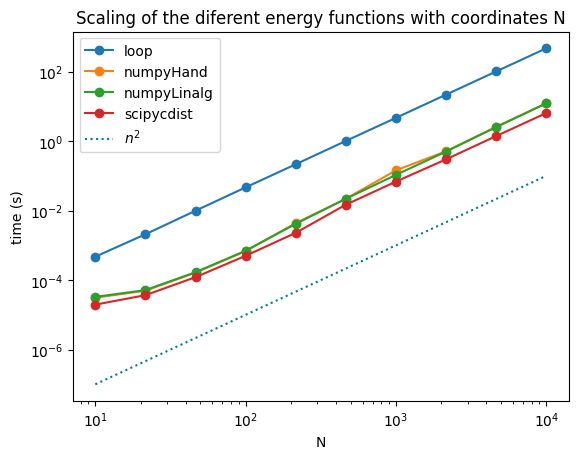

In [132]:
# Ploting df columns (timepoints)
for time in times:
    plt.loglog(nPoints,time, "o-")

# Ploting n**2 dependencies (adjusted to fit plot)
plt.plot(nPoints,nPoints**2*1e-9,":", c="teal")

# Plot settings
plt.xlabel("N"); plt.ylabel("time (s)")
plt.title("Scaling of the diferent energy functions with coordinates N")
plt.legend(["loop","numpyHand","numpyLinalg","scipycdist",r"$n^2$"])

In [136]:
# Miramos cuanto tardan y escalado segun el numero de steps
nPoints2 = np.logspace(1,5,8)
times2 = [[] for _ in range(4)]

coord1 = np.random.uniform(1,2,size=(3,3))
coord2 = np.random.uniform(1,2,size=(3,3))
A = np.random.uniform(1,2,size=(3,3))
B = np.random.uniform(1,2,size=(3,3))
q = np.random.uniform(-1,1,size=(3))
Q = np.dot(q[:,None],q[:,None].T)

for n in nPoints2:
    for i,method in enumerate([looping,numpyHand,numpyLinalg,scipycdist]):
        print(method.__name__)
        t = %timeit -o for _ in range(int(n)): method(coord1,coord2)
        times2[i].append(t.average)
times2 = np.array(times2)

looping
737 µs ± 3.29 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
numpyHand
331 µs ± 2.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
numpyLinalg
227 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
scipycdist
153 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
looping
1.6 ms ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
numpyHand
741 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
numpyLinalg
812 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
scipycdist
559 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
looping
6.02 ms ± 93.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
numpyHand
2.71 ms ± 8.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
numpyLinalg
2.94 ms ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
scipycdist
2.11 ms ± 57.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
loop

Here, you can also see the scaling and time with the number of steps. As expected all scale linearly with N. Again, using the normal loop method gives slower results than using NumPy or SciPy.

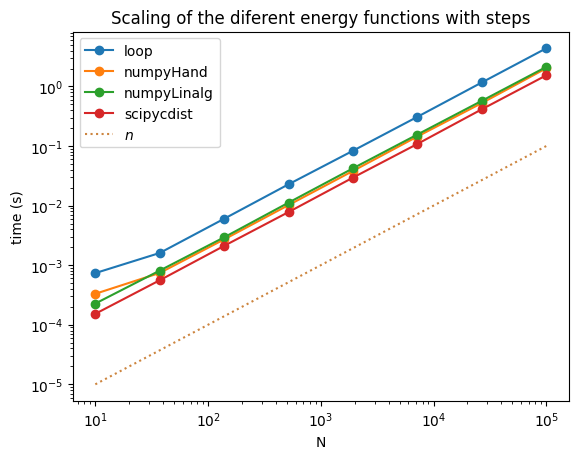

In [137]:
# Ploting df columns (timepoints)
for time in times2:
    plt.loglog(nPoints2,time, "o-")

# Ploting n dependencies (adjusted to fit plot)
plt.plot(nPoints2,(nPoints2)*1e-6,":", c="peru")

# Plot settings
plt.xlabel("N"); plt.ylabel("time (s)")
plt.title("Scaling of the diferent energy functions with steps")
plt.legend(["loop","numpyHand","numpyLinalg","scipycdist",r"$n$"])

Instead of double looping over the coordinates to calculate the energies pair by pair (very slow), you can use arrays and broadcasting to work with matrices and faster. Below are a few examples.

In [27]:
#Para poder haver vector x vector.T = matrix hay que añadir nueva dimensión (vector[:,None])
Qij = np.dot(q[:,None],q[:,None].T)
print(Qij)
#Lo mismo pasa con sumas/restas
Qijr =(q[:,None]-q[:,None].T)
print(Qijr)

[[ 0.695556 -0.347778 -0.347778]
 [-0.347778  0.173889  0.173889]
 [-0.347778  0.173889  0.173889]]
[[ 0.    -1.251 -1.251]
 [ 1.251  0.     0.   ]
 [ 1.251  0.     0.   ]]


In [10]:
#Se puede calcular la matriz de distancias con arrays y broadcasting
diff1 = coord1-coord2[:,None]
diff1 = diff1**2
diff1 = diff1.sum(axis=-1)
diff1 = np.sqrt(diff1)
print(diff1.T)


[[2.74143849 3.3613768  3.35939652]
 [1.77169806 2.42455625 2.42214822]
 [3.05079563 3.68923041 3.69204577]]


In [92]:
#Lo mismo pero mas resumido
diff = coord1-coord2[:,None]
distances = np.sqrt((diff**2).sum(axis=-1)).T
print(distances)


[[2.74143849 3.3613768  3.35939652]
 [1.77169806 2.42455625 2.42214822]
 [3.05079563 3.68923041 3.69204577]]


In [88]:
#Lo mismo pero utilizando np.linalg.norm
diff = coord1-coord2[:,None]
distances = np.linalg.norm(diff, axis=-1).T
print(distances)

[[2.74143849 3.3613768  3.35939652]
 [1.77169806 2.42455625 2.42214822]
 [3.05079563 3.68923041 3.69204577]]


In [93]:
#SciPy tiene cdist que pinta bien 
distances = sp.spatial.distance.cdist(coord1,coord2)
print(distances)
print(A/distances)

[[2.74143849 3.3613768  3.35939652]
 [1.77169806 2.42455625 2.42214822]
 [3.05079563 3.68923041 3.69204577]]
[[2.12273799e+05 9.76734804e+01 9.77310564e+01]
 [1.85312260e+02 4.00727309e-06 4.01125700e-06]
 [1.07616966e+02 2.63357338e-06 2.63156515e-06]]
